### Text preprocessing and word embedding for RNNs

## Importance of Text Preprocessing

### What is Text Preprocessing?
Text preprocessing involves cleaning and preparing raw text data to make it suitable for machine learning models. It is a critical step for achieving high performance in Natural Language Processing (NLP) tasks.

#### Key Steps in Text Preprocessing:
- **Tokenization:** Splits text into individual units (e.g., words, sentences), making it easier to analyze.
- **Stemming:** Reduces words to their root form by removing suffixes. For example, "running" and "runner" become "run". This helps group similar words together.
- **Lemmatization:** Converts words to their base or dictionary form using a vocabulary and morphological analysis. For example, "better" becomes "good". Lemmatization is generally more accurate than stemming.
- **Lowercasing:** Converts all characters to lowercase to ensure uniformity.
- **Removing Stopwords:** Eliminates common words (like "the", "is", "and") that do not contribute much meaning.
- **Removing Punctuation and Special Characters:** Cleans the text by removing unnecessary symbols.
- **Handling Misspellings:** Corrects spelling errors to standardize the text.

### Why is Preprocessing Important?
- **Reduces Noise:** Cleans irrelevant or redundant information from the data.
- **Standardizes Input:** Ensures consistency in the data fed to models.
- **Improves Feature Extraction:** Makes it easier to extract meaningful features.
- **Boosts Model Accuracy:** Clean and standardized data leads to better model performance.

---

## Introduction to Word Embedding

### What are Word Embeddings?
Word embeddings are dense vector representations of words that capture semantic meaning. They represent words in a continuous vector space, where similar words are closer together. Unlike one-hot encoding, embeddings capture relationships and context.

### Popular Word Embedding Models
- **Word2Vec:** Includes Continuous Bag of Words (CBOW) and Skip-Gram architectures. Learns word relationships based on context in large corpora.
- **GloVe (Global Vectors for Word Representation):** Uses word co-occurrence statistics to generate embeddings, capturing global semantic relationships.
- **FastText:** Developed by Facebook, it represents words as bags of character n-grams, allowing it to handle out-of-vocabulary (OOV) words.
- **Pretrained Embeddings in Frameworks:** Libraries like TensorFlow and PyTorch offer pretrained embeddings for quick integration into NLP models.

### Benefits of Word Embeddings
- **Reduce Dimensionality:** Represent words in a compact, dense form.
- **Capture Semantic Similarity:** Words with similar meanings have similar vector representations.
- **Improve Model Generalization:** Help models understand context and relationships between words.

---

## Using Pretrained Embeddings for NLP Tasks

### Why Use Pretrained Embeddings?
- **Save Computational Resources:** Avoid training embeddings from scratch.
- **Leverage Large, Well-Trained Models:** Benefit from embeddings trained on massive datasets.
- **Boost Performance:** Improve results on downstream tasks like text classification, sentiment analysis, and machine translation.

### Popular Pretrained Embeddings
- **GloVe:** Pretrained on datasets like Wikipedia and Common Crawl.
- **FastText:** Handles OOV words through subword embeddings.
- **Embedding Layers in Deep Learning Frameworks:** TensorFlow and PyTorch provide easy-to-use embedding layers and access to pretrained vectors.

---

By combining effective text preprocessing with powerful word embeddings, you can significantly enhance the performance of RNNs and other NLP models.

In [16]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Load dataset

In [17]:
vocab_size =1000
max_len =200
(X_train,y_train),(X_test,y_test) = imdb.load_data(num_words=vocab_size)

# decode reviews to text for preprocessing
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}
decoded_reviews = ["".join([reverse_word_index.get(i - 3, "?")for i in review]) for review in X_train[:5]]

# pad sequences
X_train = pad_sequences(X_train, padding="post", maxlen=max_len)
X_test = pad_sequences(X_test, padding="post", maxlen=max_len)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (25000, 200), (25000,)
Testing data shape: (25000, 200), (25000,)


load glove embeddings

In [18]:
import numpy as np

embedding_index = {}
glove_file = "glove.6B/glove.6B.100d.txt"

with open(glove_file, "r", encoding="utf-8") as file:
    for line in file:
        values = line.split()
        words = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embedding_index[words] = coefs

print(f"Loaded {len(embedding_index)} word vectors.")

# prepare embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.


build lstm model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# define lstm model with GloVe embeddings
model = Sequential(
    [
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            trainable=False,
        ),
        LSTM(128, activation="tanh", return_sequences=False),
        Dense(1, activation="sigmoid"),
    ]
)

# compile model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

# train the model
history = model.fit(
    X_train, y_train, validation_split=0.2, epochs=5, batch_size=64, verbose=1
)

glove_loss, glove_accuracy = model.evaluate(X_test, y_test)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │       100,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,000 (390.62 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 100,000 (390.62 KB)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 81ms/step - accuracy: 0.5033 - loss: 0.6946 - val_accuracy: 0.5264 - val_loss: 0.6858
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - accuracy: 0.5322 - loss: 0.6835 - val_accuracy: 0.5092 - val_loss: 0.6895
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - accuracy: 0.5415 - loss: 0.6810 - val_accuracy: 0.5560 - val_loss: 0.6699
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.5625 - loss: 0.6624 - val_accuracy: 0.5446 - val_loss: 0.6725
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - accuracy: 0.5739 - loss: 0.6509 - val_accuracy: 0.6850 - val_loss: 0.6092
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.6715 - loss: 0.6170


LSTM model without GloVe

In [20]:
# LSTM Model
lstm_model = Sequential(
    [
        Embedding(input_dim=vocab_size, output_dim=128),
        LSTM(128, activation="tanh", return_sequences=False),
        Dense(1, activation="sigmoid"),
    ]
)

lstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
lstm_model.summary()

lstm_history = lstm_model.fit(
    X_train, y_train, epochs=5, batch_size=64, validation_split=0.2
)

lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test)
print(f"LSTM Test Loss: {lstm_loss}, Test Accuracy: {lstm_accuracy}")
print(f"LSTM Model with GloVe Embeddings Test Loss: {glove_loss}, Test Accuracy: {glove_accuracy}")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 82ms/step - accuracy: 0.5324 - loss: 0.6891 - val_accuracy: 0.5958 - val_loss: 0.6398
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.6248 - loss: 0.6366 - val_accuracy: 0.7580 - val_loss: 0.5530
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.7180 - loss: 0.5694 - val_accuracy: 0.6776 - val_loss: 0.6093
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.7408 - loss: 0.5414 - val_accuracy: 0.7800 - val_loss: 0.5109
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.8064 - loss: 0.4495 - val_accuracy: 0.7782 - val_loss: 0.4547
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.7925 - loss: 0.4400
LSTM Test Loss: 0.4360848367214203, Test Accuracy: 0.7950400114059448
LSTM Model with GloVe Embeddings Test Loss: 0.6173862814903259, Test Accuracy: 0.6734799742698669


plot accuracy comparisons

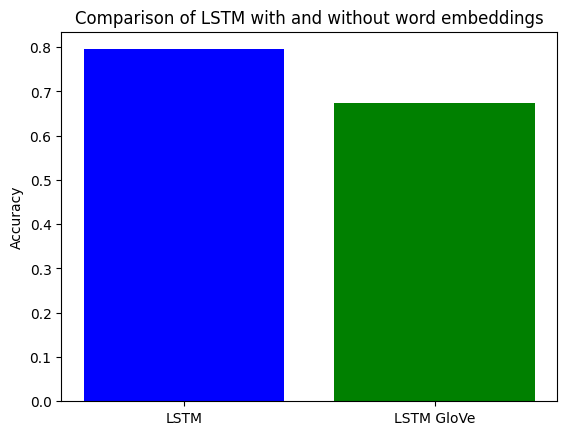

In [21]:
import matplotlib.pyplot as plt

models = ["LSTM", "LSTM GloVe"]
accuracies = [lstm_accuracy, glove_accuracy]
plt.bar(models, accuracies, color=["blue", "green"])
plt.title("Comparison of LSTM with and without word embeddings")
plt.ylabel("Accuracy")
plt.show()